[Original](https://github.com/yandexdataschool/Practical_DL)

# Finetunnig, Deep Dream and Adversarial Attacks

![img](https://images11.popmeh.ru/upload/img_cache/cea/ceaadd1ede4a7babd4b2b5dd64e4089f_fitted_800x3000.jpg)


In [2]:
import torch
print (torch.cuda.device_count())
print (torch.__version__)

1
1.3.1


In [3]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [4]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


In [5]:
print(list(filter(lambda x: 'banana' in x[1], labels.items())))

[(954, 'banana')]


# Загрузим Inception-v3

![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Посмотреть код модели: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [6]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [7]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-1.2168,  0.4693,  1.6984,  ..., -2.3453, -0.5436,  1.6883],
        [-0.9940,  1.0658,  1.9266,  ..., -2.1086, -0.6440,  1.5278],
        [-1.0598,  0.9501,  1.8536,  ..., -2.1801, -0.5328,  1.6821],
        [-1.3122,  0.8946,  1.8479,  ..., -1.9850, -0.3274,  1.3407],
        [-1.3127,  0.7843,  1.5783,  ..., -2.0559, -0.4778,  1.5477]],
       grad_fn=<AddmmBackward>)

### Предскажем вероятности классов

In [8]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

--2020-04-19 08:31:19--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2020-04-19 08:31:19 (53.3 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



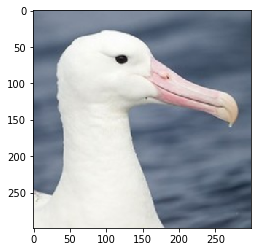

top-10 classes are: 
 [prob : class label]
0.9741 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [9]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

###  Подставьте свою ссылку на картинку  :)

In [10]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2020-04-19 08:32:27--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.5.67, 104.26.4.67, 2606:4700:20::681a:443, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.5.67|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2020-04-19 08:32:28--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.5.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0.006s  

2020-04-19 08:32:29 (7.68 MB/s) - ‘img.jpg’ saved [51048/51048]



In [ ]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

In [12]:
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg -O sample_images/mask.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2020-04-19 08:33:20--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59207 (58K) [image/jpeg]
Saving to: ‘sample_images/mask.jpg’

sample_images/mask. 100%[===================>]  57.82K  --.-KB/s    in 0.01s   

2020-04-19 08:33:20 (3.83 MB/s) - ‘sample_images/mask.jpg’ saved [59207/59207]



In [ ]:
img = resize(plt.imread('sample_images/mask.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Битва века - Котики Vs Собачки
* соревнование
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG картинок разного размера, 2 класса (угадай какие)

### Ваша задача
* fine-tune предобученную модель на новые классы
* Для этого используем предобученные слои

In [15]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip -n data.zip

File ‘data.zip’ already there; not retrieving.
Archive:  data.zip


Чтобы взять предобученные слои переопределим последний слой модели на тождественный (который не делает ничего)

In [19]:
from copy import deepcopy  # чтобы не изменять исходную модель ее копию

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        <YOUR CODE>
        
    
# redefine the last layer to be Identity
<YOUR CODE>

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from skimage.io import imread
import skimage
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

# batch_size = <YOUR VALUE>
batch_size = 256

imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))

    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = <YOUR CODE>
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

In [25]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(13312, 2048) (13312,)



 54%|█████▍    | 13557/25000 [07:29<02:25, 78.39it/s]

In [26]:
# <split data here or use cross-validation>
<YOUR CODE >

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [27]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

In [4]:
<YOUR CODE>


# Main quest

* Улучшить скор!
* Добейтесь __как минимум 95%__ на тесте.

Можно все! ensembling, boosting, data augmentation, NN.
Только не обучайтесь на тестовом множестве)

### Разбейте данные
  * please do train/validation/test instead of just train/test
  * reastrain/validation/test -  20k/2.5k/2.5k или 15k/5k/5k

### Добавьте новые слои нейронной сети

### Обучите новые слои несколько итераций отдельно
  * Например, отправив только их в оптимизатор
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * следите за скором на валидации

### Fine-tune "тело" сети
  * Сохраняйте веса!
  * Предобученной части нужен отдельный, более низкий лернинг рейт.

In [ ]:
print(cl.score(X_train[:]))

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

https://github.com/thesemicolonguy/deep-dream-pytorch

https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [1]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())
print(len(modulelist))

In [3]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True,
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True,
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)   # YOUR CODE
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))